In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/PhD/GaussianProcessNode`


In [2]:
using Revise 
using StableRNGs, GraphPPL,ReactiveMP, RxInfer, Random, Distributions, LinearAlgebra, Plots
using Flux, Zygote, ForwardDiff
using SpecialFunctions, ForwardDiff, Optim
using BenchmarkTools
import KernelFunctions: SqExponentialKernel, Matern52Kernel, with_lengthscale, Kernel, kernelmatrix  
import ReactiveMP: GaussHermiteCubature

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **



  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **



## Prepare data 

In [3]:
function generate_data(n,x_0, f_gp, σ_x, σ_y)
    y=[]
    x = []
    obs = []
    x_prev = x_0
    for i=1:n
        x_t = σ_x * randn() 
        temp = x_t * exp(f_gp[i]) 
        push!(y,temp)
        push!(x,x_t)    
        push!(obs, temp + σ_y*randn())
    end
    return x, y , obs
end

generate_data (generic function with 1 method)

In [25]:
Random.seed!(1)

σ_x = 2pi/30 # true frequency
σ_y = 0.0001 ## we assume low noise for now
x_init = 2.0

N = 400; #data length
n = 400; #length of the axis of gp 

## GP information
meanf = (x) -> 0.0;
kernel(θ) = with_lengthscale(SqExponentialKernel(),θ)
tmin,tmax = 0., 4.0
time_range = collect(range(tmin, tmax; length=n));

θ_gp = 0.1 #true θ_gp

Cov_mat = kernelmatrix(kernel(θ_gp),time_range,time_range) + 1e-8*I;
gp = MvNormal(meanf.(time_range), Cov_mat)
f_test = rand(gp)

#Observe data 
pos = sort(randperm(n)[1:N]); # position where we observe data
time_train = time_range[pos]
f_train = f_test[pos];

In [26]:
#Generate data 
x_true_state,y_true_state,y_data = generate_data(N,x_init,f_train,σ_x,σ_y);

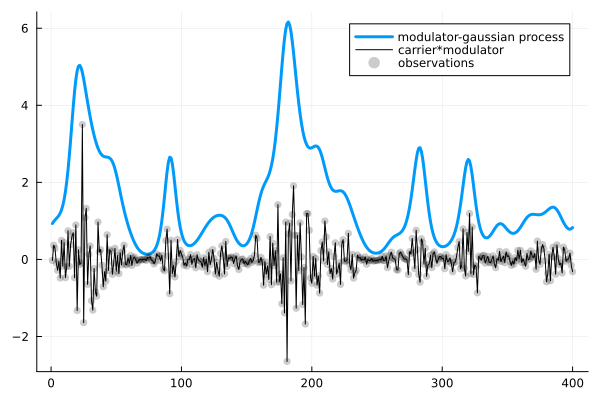

In [27]:
plot(exp.(f_train), label="modulator-gaussian process",linewidth=3.0)
plot!(y_true_state,label="carrier*modulator",color=:black)

scatter!(y_data, color=:black,label = "observations",alpha=0.2)

## Specify model

In [7]:
#Exponentiate function 
struct MyExponential end

@node MyExponential Deterministic [ y, x ]   ## x: input,  y: output

In [8]:
### rule for y 
##TODO: this rule needs to be investigated for speed vs. accuracy 
@rule MyExponential(:y, Marginalisation) (m_x::GaussianProcess, meta::ProcessMeta) = begin
    index = meta.index
    m_gp, cov_gp = mean_cov(m_x.finitemarginal)
    dist = LogNormal(m_gp[index],cov_gp[index,index]+1e-2)
    return dist
end

### rule for x
@rule MyExponential(:x, Marginalisation) (m_y::ContinuousUnivariateLogPdf, meta::ProcessMeta) = begin
    log_pdf = (x) -> logpdf(m_y,exp(x)) 
    return ContinuousUnivariateLogPdf(log_pdf)
end


@rule MyExponential(:y, Marginalisation) (m_x::UnivariateGaussianDistributionsFamily, meta::ProcessMeta) = begin 
    dist = LogNormal(mean(m_x), var(m_x))
    return dist
end
    
@rule MyExponential(:x, Marginalisation) (m_y::UnivariateGaussianDistributionsFamily, meta::ProcessMeta) = begin 
    μ_y, var_y =  mean_var(m_y)
    log_pdf = (x) -> logpdf(NormalMeanVariance(μ_y, var_y),exp(x)) 
    return ContinuousUnivariateLogPdf(log_pdf)
end

## Model

In [9]:
#GP Amplitude Demodulation model 
@model function gp_AmplitudeDemodulation(n, gp_kernel,gp_mean, train,test, gpstrategy)
    f = randomprocess(test, train, gpstrategy)
    y = datavar(Float64,n)
    g = randomvar(n)
    z = randomvar(n)
    w = randomvar(n)
    
    # θ ~ NormalMeanVariance(log(0.5), 50.)
    # β ~ GammaShapeRate(1., .01)
    # θ ~ NormalMeanVariance(log(0.6),50.)
    f ~ GaussianProcess(gp_mean, gp_kernel, log(0.1)) #where {pipeline = RequireMarginal(params)}
    for i=1:n 
        z[i] ~ NormalMeanPrecision(0.0,1/(σ_x)^2) #where {pipeline = RequireMessage(τ)}
        g[i] ~ MyExponential(f) where {meta = ProcessMeta(i)}
#         g[i] ~ MyExponential(f) where {meta = ProcessMeta(i),pipeline = RequireMessage(x = NormalMeanPrecision(1.0, 10.0))}
        w[i] ~ (*)(z[i],g[i]) where {meta = TinyCorrection()}
        y[i] ~ NormalMeanPrecision(w[i], 1/σ_y^2)
    end
end

In [10]:
# @rule typeof(*)(:in, Marginalisation) (m_out::UnivariateGaussianDistributionsFamily, m_A::UnivariateGaussianDistributionsFamily, meta::TinyCorrection) = begin 
#     μ_in, var_in = mean_var(m_A)
#     μ_out, var_out = mean_var(m_out)
    
#     backwardpass = (x) -> -log(abs(x)) - 0.5*log(2π * (var_in + var_out / x^2))  - 1/2 * (μ_out / x - μ_in)^2 / (var_in + var_out / x^2)
#     return ContinuousUnivariateLogPdf(backwardpass)
# end


# @rule typeof(*)(:A, Marginalisation) (m_out::UnivariateGaussianDistributionsFamily, m_in::LogNormal, meta::ProcessMeta) = begin 
#     return @call_rule typeof(*)(:A, Marginalisation) (m_out=m_out,m_in=m_in,meta=TinyCorrection())
# end



# @rule typeof(*)(:in, Marginalisation) (m_out::NormalMeanPrecision, m_A::GaussianProcess, meta::ProcessMeta) = begin 
    
#     index = meta.index
#     m_gp, cov_gp = mean_cov(m_A.finitemarginal)
#     kernelf = m_A.kernelfunction
#     meanf   = m_A.meanfunction
#     test    = m_A.testinput
#     train   = m_A.traininput
#     cov_strategy = m_A.covariance_strategy
#     x_u = m_A.inducing_input
#     mμ, var_μ = ReactiveMP.predictMVN(cov_strategy, kernelf,meanf,test,[train[index]],m_gp, x_u) #this returns negative variance 
#     μ_in = mμ[1]
#     var_in = var_μ[1]
#     d_A = NormalMeanVariance(μ_in, var_in)
    
    
#     return @call_rule typeof(*)(:in, Marginalisation) (m_out=m_out,m_A=d_A,meta=TinyCorrection())
# end
#use Gaussian GaussHermiteCubature to approximate 
#Temporarily put here 
function ReactiveMP.prod(::ProdAnalytical, left::UnivariateGaussianDistributionsFamily, right::ContinuousUnivariateLogPdf) 
    #we use Gaussian Hermite Cubature here, not ProdAnalytical 
    meta = GaussHermiteCubature(131)
    m,v = ReactiveMP.approximate_meancov(meta, z -> exp(right.logpdf(z)), mean(left), var(left))
    return NormalMeanVariance(m,v)
end

function ReactiveMP.prod(::ProdAnalytical, left::ContinuousUnivariateLogPdf, right::UnivariateGaussianDistributionsFamily)
    meta = GaussHermiteCubature(131)
    m,v = ReactiveMP.approximate_meancov(meta, z -> exp(left.logpdf(z)), mean(right), var(right))
    return NormalMeanVariance(m,v)
end


function ReactiveMP.prod(::ProdAnalytical, left::LogNormal, right::ContinuousUnivariateLogPdf) 
    sample_left = rand(left,1000)
    weights = [exp(logpdf(right,sample_left[i])) for i=1:length(sample_left)]
    weight = weights / sum(weights)
    m = sum(weight .* log.(sample_left))
    v = sum(weight .* (log.(sample_left) .- m).^2)
    return LogNormal(m,v)
end

@rule NormalMeanVariance(:v, Marginalisation) (m_out::ContinuousUnivariateLogPdf, q_μ::PointMass, ) = begin 
    m,v = mean_var(m_out)
    d_out = NormalMeanVariance(m,v)
    return @call_rule NormalMeanVariance(:v, Marginalisation) (q_out=d_out, q_μ=q_μ, ) 
end

@rule NormalMeanVariance(:out, Marginalisation) (q_μ::PointMass, m_v::InverseGamma, ) = begin 
    return  @call_rule NormalMeanVariance(:out, Marginalisation) (q_μ=q_μ, q_v=m_v, )
end

@rule NormalMeanPrecision(:τ, Marginalisation) (m_out::ContinuousUnivariateLogPdf, q_μ::PointMass, ) = begin 
    m,v = mean_var(m_out)
    d_out = NormalMeanVariance(m,v)
    return @call_rule NormalMeanPrecision(:τ, Marginalisation) (q_out=d_out, q_μ =q_μ , )
end

@rule NormalMeanPrecision(:out, Marginalisation) (q_μ::PointMass, m_τ::Gamma, ) = begin 
    return  @call_rule NormalMeanPrecision(:out, Marginalisation) (q_μ=q_μ, q_τ=m_τ, )
end

@rule GaussianProcess(:params, Marginalisation) (m_out::GaussianProcess, q_meanfunc::Any, q_kernelfunc::Any, q_params::UnivariateGaussianDistributionsFamily, meta::Unscented) = begin 
    return @call_rule GaussianProcess(:params, Marginalisation) (q_out=m_out, q_meanfunc=q_meanfunc, q_kernelfunc=q_kernelfunc, q_params=q_params, meta=meta)
end

@rule typeof(*)(:A, Marginalisation) (m_out::UnivariateGaussianDistributionsFamily, m_in::UnivariateGaussianDistributionsFamily, meta::ProcessMeta) = begin 
    return @call_rule typeof(*)(:A, Marginalisation) (m_out=m_out,m_in=m_in,meta=TinyCorrection())
end

## Rule for multiplication node

In [11]:
# ##EP for NormalMeanPrecision
# @rule NormalMeanPrecision(:τ, Marginalisation) (m_out::ContinuousUnivariateLogPdf, q_μ::PointMass, m_τ::GammaDistributionsFamily, ) = begin 
#     #aprroximate m_out as normal 
#     mμ = mean(q_μ)
# #     μ_out, v_out = mean_var(m_out)
#     res = optimize(x -> -logpdf(m_out,x),-50,50)
#     μ_out = res.minimizer
#     # use laplace approximation
#     dx = (x) -> ForwardDiff.derivative(y -> -logpdf(m_out, y),x)
#     ddx = (x) -> ForwardDiff.derivative(dx, x)
#     v_out = cholinv(ddx(μ_out))
    
#     proposal = m_τ
#     n_samples     = 10000

#     logpdf_τ = (x) -> logpdf(GammaShapeRate(1.5, 0.5 * (μ_out - mμ)^2), x / (x * v_out + 1))
#     log_integrand = ContinuousUnivariateLogPdf(logpdf_τ)


#     samples_ν = zeros(n_samples)
#     weights_ν = zeros(n_samples)
#     uweights  = zeros(n_samples)
    
#     samples_ν = rand!(proposal, samples_ν)
#     weights_ν = map!(s -> pdf(proposal, s), weights_ν, samples_ν)
#     uweights = map!(x -> exp(log_integrand(x)), uweights, samples_ν)

#     map!(Base.Fix2(/, sum(uweights)), uweights, uweights)
#     x = mapreduce(((weight, sample), ) -> weight * sample, +, zip(uweights, samples_ν))
#     logx = mapreduce(((weight, sample), ) -> weight * log(sample), +, zip(uweights, samples_ν))
#     statistics = GammaSufficientStatistics(x, logx)
#     approximation = solve_differential_identity(statistics, proposal)
#     return approximation
# end


In [12]:
# function ReactiveMP.mean_var(p::ContinuousUnivariateLogPdf)
#     meta = GaussHermiteCubature(221)
#     res = optimize(x -> -logpdf(p,x),-50,50)
#     m0 = res.minimizer

#     v0 =  50.0
#     m,v = ReactiveMP.approximate_meancov(meta, z -> exp(p.logpdf(z)-logpdf(NormalMeanVariance(m0,v0),z)), m0, v0)
# #     isnan(v) ? v = 1. : v=v
#     return m0,v
# end

# Distributions.mean(p::ContinuousUnivariateLogPdf) = mean_var(p)[1]
# Distributions.var(p::ContinuousUnivariateLogPdf) = mean_var(p)[2]

In [13]:
# #use Gaussian GaussHermiteCubature to approximate 
# #Temporarily put here 
# function ReactiveMP.prod(::ProdAnalytical, left::UnivariateGaussianDistributionsFamily, right::ContinuousUnivariateLogPdf) 
#     #we use Gaussian Hermite Cubature here, not ProdAnalytical 
#     meta = GaussHermiteCubature(131)
#     m,v = ReactiveMP.approximate_meancov(meta, z -> exp(right.logpdf(z)), mean(left), var(left))
#     return NormalMeanVariance(m,v)
# end

# function ReactiveMP.prod(::ProdAnalytical, left::ContinuousUnivariateLogPdf, right::UnivariateGaussianDistributionsFamily)
#     meta = GaussHermiteCubature(131)
#     m,v = ReactiveMP.approximate_meancov(meta, z -> exp(left.logpdf(z)), mean(right), var(right))
#     return NormalMeanVariance(m,v)
# end


# function ReactiveMP.prod(::ProdAnalytical, left::LogNormal, right::ContinuousUnivariateLogPdf) 
#     sample_left = rand(left,1000)
#     weights = [exp(logpdf(right,sample_left[i])) for i=1:length(sample_left)]
#     weight = weights / sum(weights)
#     m = sum(weight .* log.(sample_left))
#     v = sum(weight .* (log.(sample_left) .- m).^2)
#     return LogNormal(m,v)
# end

# @rule NormalMeanVariance(:v, Marginalisation) (m_out::ContinuousUnivariateLogPdf, q_μ::PointMass, ) = begin 
#     m,v = mean_var(m_out)
#     d_out = NormalMeanVariance(m,v)
#     return @call_rule NormalMeanVariance(:v, Marginalisation) (q_out=d_out, q_μ=q_μ, ) 
# end

# @rule NormalMeanVariance(:out, Marginalisation) (q_μ::PointMass, m_v::InverseGamma, ) = begin 
#     return  @call_rule NormalMeanVariance(:out, Marginalisation) (q_μ=q_μ, q_v=m_v, )
# end

# @rule NormalMeanPrecision(:τ, Marginalisation) (m_out::ContinuousUnivariateLogPdf, q_μ::PointMass, ) = begin 
#     m,v = mean_var(m_out)
#     d_out = NormalMeanVariance(m,v)
#     return @call_rule NormalMeanPrecision(:τ, Marginalisation) (q_out=d_out, q_μ =q_μ , )
# end

# @rule NormalMeanPrecision(:out, Marginalisation) (q_μ::PointMass, m_τ::Gamma, ) = begin 
#     return  @call_rule NormalMeanPrecision(:out, Marginalisation) (q_μ=q_μ, q_τ=m_τ, )
# end

# @rule GaussianProcess(:params, Marginalisation) (m_out::GaussianProcess, q_meanfunc::Any, q_kernelfunc::Any, q_params::UnivariateGaussianDistributionsFamily, meta::Unscented) = begin 
#     return @call_rule GaussianProcess(:params, Marginalisation) (q_out=m_out, q_meanfunc=q_meanfunc, q_kernelfunc=q_kernelfunc, q_params=q_params, meta=meta)
# end



In [14]:
@constraints function gpconstraints()   
    q(f,θ) = q(f)q(θ)
end

gpconstraints (generic function with 1 method)

In [15]:
function SE_stationary_vector(delta,v,l;jitter=1e-12)
    return v*exp.(-0.5 .* delta.^2 / l^2) 
end

function Periodic_stationary_vector(delta,v,l,p; jitter=1e-12)
    """
    delta: vector Δτ
    v: variance of the process 
    l: length-scale 
    p: periodic 

    return a stationary vector 
    """
    return v * exp.(-2 * (sin.(π/p * abs.(delta))).^2 / l^2)
end

function circularize(arr)
    arrlength      = length(arr)
    circularlength = 2*(arrlength-1)
    
    circulararr    = Array{eltype(arr)}(undef,circularlength)
    
    @views circulararr[1:arrlength] .= view(arr,:,1)
    @inbounds [circulararr[i] = arr[arrlength - i%arrlength] for i=arrlength+1:circularlength]
    
    return circulararr
end

circularize (generic function with 1 method)

In [99]:
cov_strategy = CovarianceMatrixStrategy(RandomFourierFeature(100))
delta_time_range = time_range .- time_range[1]
amplitude_stationary_vector(θ) = SE_stationary_vector(delta_time_range, 1., θ) 

amplitude_stationary_vector (generic function with 1 method)

In [100]:
nits =3

iresult = inference(
    model = gp_AmplitudeDemodulation(length(y_data), kernel, meanf, time_range,time_range, cov_strategy),
    iterations = nits, 
    data  = (y = y_data,),
    returnvars = (f = KeepEach(), ),#θ = KeepEach(),),
    showprogress = true,
    free_energy = false
)


Progress:  67%|███████████████████████████▍             |  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Inference results:
  Posteriors       | available for (f)


In [101]:
mgp = mean(iresult.posteriors[:f][end].data.finitemarginal)
vgp = var(iresult.posteriors[:f][end].data.finitemarginal)
expvgp = exp.( mgp .+ vgp)
expmgp = exp.(mgp);

In [102]:
iresult.posteriors[:f][end].data.finitemarginal

MvNormalMeanCovariance(
μ: [0.144246769422137, 0.1923255509337273, 0.2478069667507759, 0.31237760676076803, 0.3871322231482927, 0.4724431888630149, 0.5678893344551524, 0.6722501314236372, 0.7835655944709317, 0.8992566717211972  …  0.08819567681114446, 0.04936953836850162, 0.014035035021545, -0.018752215320223656, -0.05043835418698711, -0.08279434331134988, -0.11770633452407082, -0.15695199869721654, -0.20198279564069077, -0.25373175666246456]
Σ: [0.8000000000000006 0.7960185468542472 … -0.03896139441050733 -0.03123584549564977; 0.7960185468542472 0.8000000000000006 … -0.04577956289096632 -0.03896139441050738; … ; -0.03896139441050733 -0.04577956289096632 … 0.8 0.7960185468542468; -0.03123584549564977 -0.03896139441050738 … 0.7960185468542468 0.8000000000000004]
)


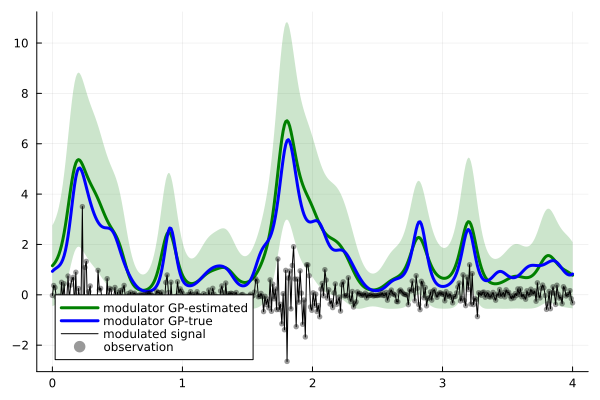

In [103]:
plot(time_range,expmgp,ribbon=sqrt.(expvgp),linewidth=3.0,label="modulator GP-estimated",fillalpha=0.2,color=:green)
# plot!(time_range,-expmgp,ribbon=sqrt.(expvgp),linewidth=3.0,label="modulator GP-estimated",fillalpha=0.2,color=:green)
plot!(time_range,exp.(f_test), label="modulator GP-true",linewidth=3.0,color=:blue)
plot!(time_train,y_true_state, label="modulated signal",color=:black)
scatter!(time_train,y_data, label="observation",color=:black,alpha=0.4,ms=3,legend=:bottomleft)
# plot!(time_range,mean.(iresult.posteriors[:g][end]),ribbon=var.(iresult.posteriors[:g][end]))

In [425]:
iresult.posteriors[:θ][end]

NormalWeightedMeanPrecision{Float64}(xi=-0.0076049243721559865, w=0.020111935661507672)

In [426]:
exp.(mean.(iresult.posteriors[:θ]))

10-element Vector{Float64}:
 0.6283086653529224
 0.5079290738428307
 0.8518613019118111
 0.538966444500999
 0.5666660300471216
 0.537749689193095
 0.4923432789897692
 0.7337288966486327
 0.5968295651855248
 0.68514148983824

In [61]:
β_infer = mean(iresult.posteriors[:β][end])
inv(sqrt(β_infer))
β_range = collect(0. : 0.01: 100.);
plot(β_range, pdf.(iresult.posteriors[:β][end],β_range), label="posterior β")
vline!([1/(2pi/10)^2], label="True carrier freq")

KeyError: KeyError: key :β not found

In [62]:
plot(1:nits, mean.(iresult.posteriors[:β]))
hline!([1/(2pi/10)^2])

KeyError: KeyError: key :β not found

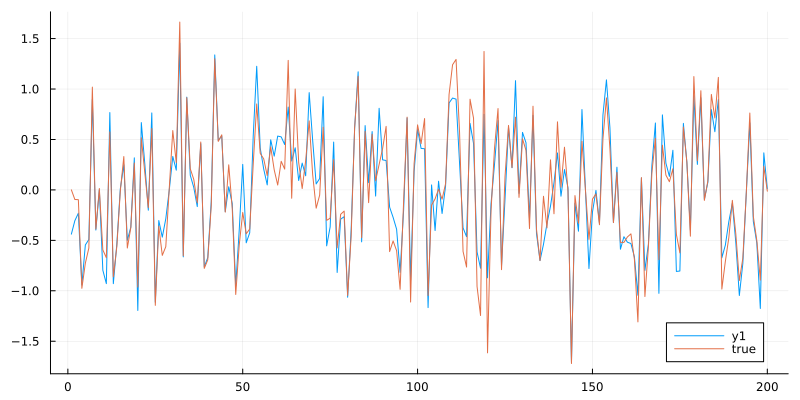

In [63]:
plot(mean.(iresult.posteriors[:z][end]), size = (800,400))
plot!(x_true_state,label="true")

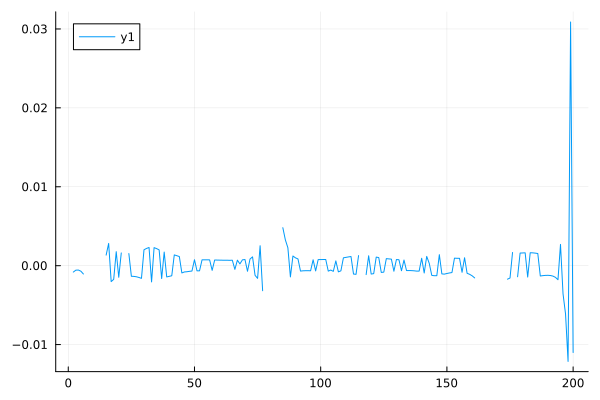

In [373]:
plot(expmgp .* (mean.(iresult.posteriors[:z][end])))

In [285]:
#compare w and y_data 
# plot(mean.(iresult.posteriors[:w][end]), size = (800,400), lw = 1.5)
plot(y_true_state,label="true")
plot!(expmgp .* (mean.(iresult.posteriors[:z][end])))

KeyError: KeyError: key :z not found

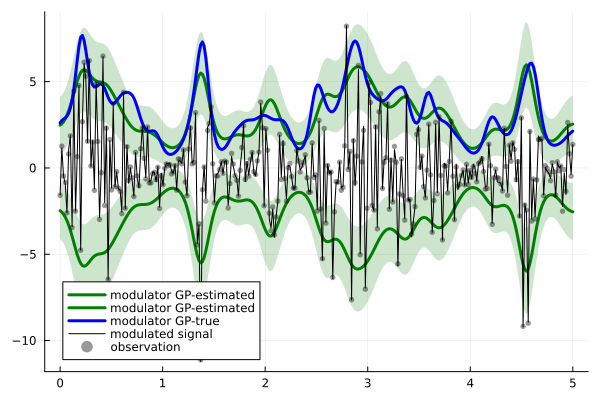

In [69]:
plot(time_range,expmgp,ribbon=sqrt.(expvgp),linewidth=3.0,label="modulator GP-estimated",fillalpha=0.2,color=:green)
plot!(time_range,-expmgp,ribbon=sqrt.(expvgp),linewidth=3.0,label="modulator GP-estimated",fillalpha=0.2,color=:green)
plot!(time_range,exp.(f_test), label="modulator GP-true",linewidth=3.0,color=:blue)
plot!(time_train,y_true_state, label="modulated signal",color=:black)
scatter!(time_train,y_data, label="observation",color=:black,alpha=0.4,ms=3,legend=:bottomleft)


In [63]:
iresult.posteriors[:f][end].covariance_strategy

CovarianceMatrixStrategy{DeterministicInducingConditional{MersenneTwister}}(DeterministicInducingConditional{MersenneTwister}(90, MersenneTwister(1, (0, 2004, 1002, 338)), [0.3 0.29583460407751794 … 0.0 0.0; 0.29583460407751794 0.3 … 0.0 0.0; … ; 0.0 0.0 … 0.3 0.28368222584365554; 0.0 0.0 … 0.28368222584365554 0.3], [0.2645274313318668 0.28368222584361047 … 0.0 0.0; 0.23986381636653997 0.2645274313318668 … 0.0 0.0; … ; 0.0 0.0 … 0.23986381636658344 0.2115018640429918; 0.0 0.0 … 0.28368222584352654 0.264527431331811], [475.13502195177784 -588.1758994361937 … 0.006140127328022241 -0.001187528095641605; -588.1758994361937 731.038840999327 … -0.008157412869296266 0.0015776801444861823; … ; 0.006140127328022241 -0.008157412869296266 … 112347.12720629867 -24592.54122581621; -0.001187528095641605 0.0015776801444861823 … -24592.54122581621 5495.150138599959], [9.312998237530001 0.0 … 0.0 0.0; 0.0 10.819479071059137 … 0.0 0.0; … ; 0.0 0.0 … 11.418168428159012 0.0; 0.0 0.0 … 0.0 9.15994566603827

In [640]:
using ToeplitzMatrices
using FFTW

function makecircular(inputarray)
    nsamples = length(inputarray)
    N        = 2*(nsamples - 1)
    arr      = Array{eltype(inputarray)}(undef,N)
    @views arr[1:nsamples] = view(inputarray,:,1)
    tmp      = [@inbounds inputarray[nsamples - (i % nsamples) ] for i=nsamples+1:N]
    @views arr[nsamples+1:end] = view(tmp,:,1)
      
    return arr
end

function makecircularwith(inputarray,e)
    nsamples = length(inputarray)
    N        = 2*(nsamples - 1)
    arr      = Array{eltype(inputarray)}(undef,N)
    @views arr[1:nsamples] = view(inputarray,:,1)
    @views arr[nsamples+1:end] .= e
      
    return arr
end

function fastcompute(u,y)
    return real(sum(abs.(fft(y)).^2 ./ fft(u))/length(y)), real.(ifft(fft(y).*fft(u))), real.(ifft(fft(y)./fft(u))) 
end


# t = collect(0:0.1:1.0)
t = randn(10)
x = makecircular(t)
u = view(kernelmatrix(kernel(2.5),x),:,1)
# y = makecircularwith(randn(length(t)),0)
y = makecircular(randn(length(t)))
# @show y' *inv((Circulant(u)))*y
# @show sum(abs.(fft(y)).^2 ./ fft(u))/length(x)
fastcompute(u,y)

(-174.78180520353558, [-0.03690250399029349, 0.005361099298732765, -0.02575139563878533, 0.40795744587811344, 0.11791310672048014, 0.2663691036797119, 0.24243755758894922, 0.1803571346631299, 0.01801761126418486, 0.2993331237174917, 0.0180176112641848, 0.18035713466312986, 0.24243755758894922, 0.266369103679712, 0.1179131067204802, 0.40795744587811344, -0.025751395638785472, 0.0053610992987326665], [17.555045251499127, -34.50697245946222, 1.347438336077578, 30.297743821267318, -44.70366113724608, 42.95357958406672, -18.22151067452682, -4.177135044665328, 26.55926727968436, -16.54465543737897, 26.559267279684338, -4.177135044665255, -18.221510674526893, 42.95357958406676, -44.703661137246044, 30.29774382126724, 1.3474383360776552, -34.50697245946224])

In [13]:
using Plots

In [14]:
y' *inv((Circulant(u)))*y

-143.46789701715502

In [8]:
y[1:length(t)]'*cholinv(kernelmatrix(kernel(0.5),t,t))*y[1:length(t)]

1.9717129777514696e18

In [92]:
using FFTW, LinearAlgebra

In [2836]:
# shifted_index = fftshift(fftfreq(length(x))*length(x))

# make_circular!(ypadded)
Acircular = kernelmatrix(kernel(θ_gp),x,x) + 1e-8I;
uvect = Acircular[:,1];

In [2846]:
ffty = rfft(ypadded);
fftu = rfft(uvect)

@time ifft(ffty .* fftu)[1:nsamples]

  0.017762 seconds (31 allocations: 49.062 KiB)


1000-element Vector{ComplexF64}:
  -0.11065520146852031 - 7.116212428440154e-16im
   -0.1091593349524519 - 0.14819859320432208im
  -0.10467318181914743 - 0.2963137907801927im
   -0.0972008338937685 - 0.4442623412598123im
  -0.08674924656434632 - 0.5919611072652229im
  -0.07332811073896482 - 0.7393272790669363im
  -0.05694984677228604 - 0.8862785254938425im
 -0.037629584355845506 - 1.0327328884402298im
 -0.015385241410927848 - 1.1786090486068608im
  0.009762668278113779 - 1.3238264118383225im
  0.037790909967694464 - 1.4683050577556709im
    0.0686737149239616 - 1.6119660984708903im
   0.10238255570891125 - 1.754731467405131im
                       ⋮
   0.10238255570891533 + 1.7547314674051309im
   0.06867371492396024 + 1.611966098470889im
   0.03779090996769719 + 1.4683050577556687im
  0.009762668278116962 + 1.3238264118383218im
 -0.015385241410925574 + 1.1786090486068592im
  -0.03762958435584142 + 1.0327328884402274im
  -0.05694984677228786 + 0.8862785254938431im
  -0.073328110738964

In [2845]:
@time (Acircular[1:nsamples,1:nsamples])*ypadded[1:nsamples]

  0.006424 seconds (7 allocations: 7.645 MiB)


1000-element Vector{Float64}:
 -2.913109949454852
 -2.915887432401912
 -2.9182728291203315
 -2.9202627407817303
 -2.9218539111045883
 -2.9230430981160898
 -2.9238272395382485
 -2.924203347740067
 -2.924168536473067
 -2.9237200134098433
 -2.9228551399135787
 -2.9215713119256534
 -2.9198660636330174
  ⋮
  1.3912795205355866
  1.3642733082623375
  1.337580196506469
  1.3111999098073315
  1.2851320696606743
  1.259376276344438
  1.23393207240831
  1.2087989125564225
  1.183976220863267
  1.159463359117247
  1.135259630138748
  1.1113642627733462

In [118]:
f = x -> -log( abs(x[1]) + 1e-8 ) - 0.5*log(2π * (3. + 0.1 / x[1]^2))  - 1/2 * (2. / x[1] - 1.)^2 / (3. + 0.1 / x[1]^2)
derivative_f = x -> ForwardDiff.derivative(f, x)

#315 (generic function with 1 method)

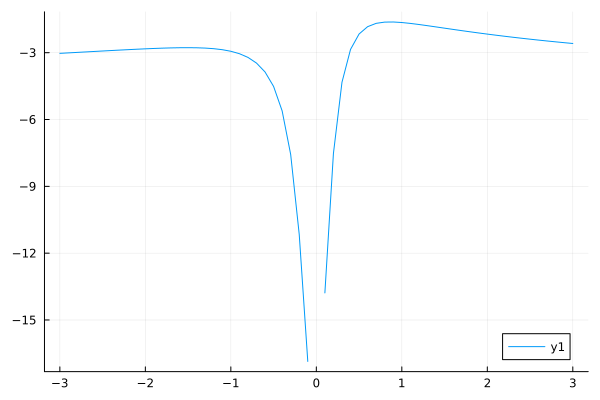

In [124]:
test = -3:0.1:3;
plot(test, f.(test))

In [120]:
find_zeros(derivative_f,-100,100)

Float64[]

In [127]:
res = optimize(f,[0.1], GradientDescent())


 * Status: success

 * Candidate solution
    Final objective value:     -1.993857e+01

 * Found with
    Algorithm:     Gradient Descent

 * Convergence measures
    |x - x'|               = 5.35e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.13e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.66e-10 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.31e-12 ≰ 0.0e+00
    |g(x)|                 = 0.00e+00 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    4
    f(x) calls:    19
    ∇f(x) calls:   19


In [128]:
res.minimizer

1-element Vector{Float64}:
 -0.017094082858806935

In [116]:
t(x) = (x[1] - 2) ^ 2

t (generic function with 1 method)

In [117]:
result = optimize(t,[100.],BFGS())

 * Status: success

 * Candidate solution
    Final objective value:     1.012392e-19

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 9.80e+01 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.90e+01 ≰ 0.0e+00
    |f(x) - f(x')|         = 9.60e+03 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.49e+22 ≰ 0.0e+00
    |g(x)|                 = 6.36e-10 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    1
    f(x) calls:    3
    ∇f(x) calls:   3


In [107]:
result.minimizer

1-element Vector{Float64}:
 1.999999999681819

In [44]:
function foo(x)
    if isnan(x)
        a = 12.
    else 
        a = 13.
    end
    return a
end

foo (generic function with 1 method)

In [46]:
foo(NaN)

12.0

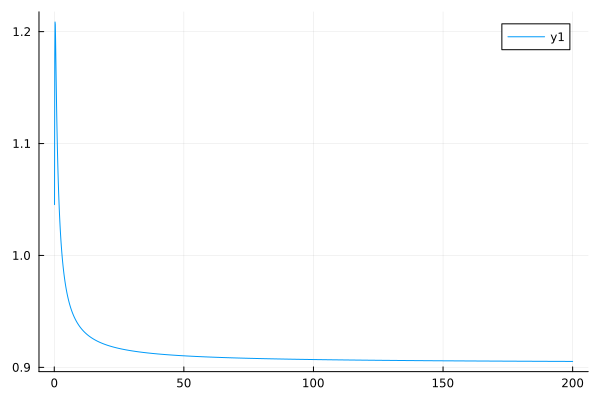

In [86]:
x = collect(0.1:0.1:200)
plot(x, pdf.(GammaShapeRate(1.5, 2.5), x ./ (x .* 2 .+ 1)))

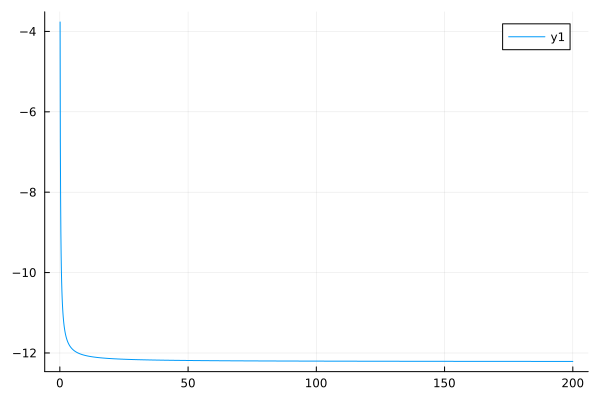

In [109]:
logpdf_τ = (x) -> logpdf(GammaShapeRate(1.5, 0.5 * (22. - 0.5)^2), x / (x * 12 + 1))
plot(x, logpdf_τ.(x))

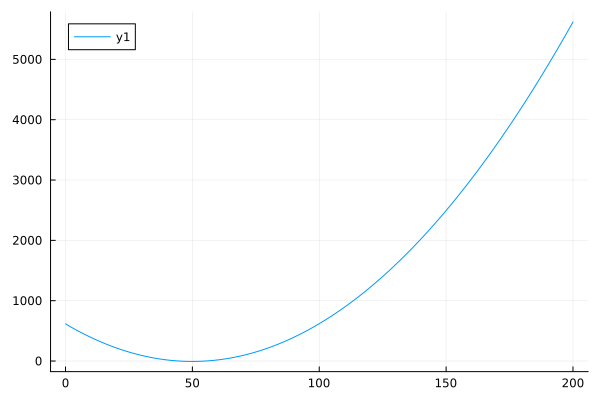

In [112]:
logpdf_normal_τ = (x) -> log(x) + logpdf(GammaShapeRate(1.5, 0.5 * (22. - 0.5)^2), x / (x * 12 + 1)) - logpdf(NormalMeanVariance(50., 2),x)
plot(x, logpdf_normal_τ.(x))

In [2]:
using Plots

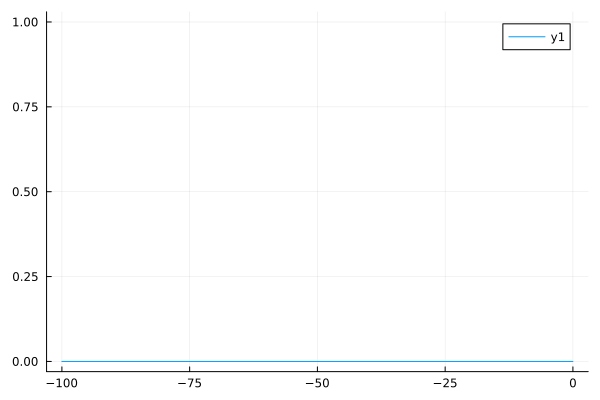

In [8]:
x = collect(-100.:0.01:-0.0001)
backwardpass = (x) -> -log(-x) - 0.5*log(2π * (.01 + 0.1^2 / ((x)^2)))  - 0.5 * (6. / (x) - 6.)^2 / (.01 + 0.1^2 / (x)^2)
plot(x, exp.(backwardpass.(x)))


In [5]:
log(exp(-6^2 / (2*0.1^2)))

-Inf

In [101]:
exp(backwardpass(0))

0.0

In [90]:
a < log(1e-4)

true

In [81]:
m_,v_ = ReactiveMP.approximate_meancov(ghcubature(21), z -> exp(backwardpass(z)), 1e-6  , 1.0)

(3.8778083878222738, 0.2010576738928998)

In [82]:
exp(backwardpass(1e-6))

0.0

In [83]:
log(1e-4)

-9.210340371976182

In [84]:
exp((log(1e-4)))

0.00010000000000000009